In [1]:
!pip install -q gdown

In [2]:
import gdown
import zipfile

In [3]:
file_id = "1-7sCyJ7uYRucNJbCtBKlzaqLupj-X2qR"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "YOLO.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-7sCyJ7uYRucNJbCtBKlzaqLupj-X2qR
From (redirected): https://drive.google.com/uc?id=1-7sCyJ7uYRucNJbCtBKlzaqLupj-X2qR&confirm=t&uuid=77501d83-44f9-442e-8bc9-a99cfd6ab7f1
To: /content/YOLO.zip
100%|██████████| 2.42G/2.42G [00:21<00:00, 112MB/s]


'YOLO.zip'

In [4]:
with zipfile.ZipFile("YOLO.zip", 'r') as zip_ref:
    zip_ref.extractall("yolo")

In [4]:
from pathlib import Path
from shutil import move
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [5]:
yaml_content = f"""# Dataset configuration for YOLO
train: ../train/images
val: ../val/images
test: ../test/images

# Number of classes
nc: 7

# Class names (index starts from 0)
names: ['sedan', 'minibus', 'truck', 'pickup', 'bus', 'cement truck', 'trailer']
"""

yaml_file = os.path.join('/content/yolo', 'data.yaml')
with open(yaml_file, 'w') as f:
    f.write(yaml_content)

In [6]:
root_dir = Path("/content/yolo")
IMG_SIZE = 224
BATCH_SIZE = 8

In [7]:
def load_image_and_label(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0

    label_text = tf.io.read_file(label_path)
    label_lines = tf.strings.strip(tf.strings.split(label_text, '\n'))
    label_elements = tf.strings.split(label_lines)
    label_data = tf.strings.to_number(label_elements, tf.float32)
    label_data = tf.reshape(label_data, [-1, 5])  # [N, 5]

    return image, label_data

In [8]:
def create_dataset(image_dir, label_dir):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
    label_files = [os.path.join(label_dir, os.path.basename(f).replace('.jpg', '.txt')) for f in image_files]

    dataset = tf.data.Dataset.from_tensor_slices((image_files, label_files))
    dataset = dataset.map(lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
train_dataset = create_dataset("yolo/train/images", "yolo/train/labels")
valid_dataset = create_dataset("yolo/val/images", "yolo/val/labels")

In [10]:
def visualize_sample(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    with open(label_path, 'r') as f:
        lines = f.readlines()

    boxes = []
    for line in lines:
        cls, x_center, y_center, w, h = map(float, line.strip().split())
        x_center *= IMG_SIZE
        y_center *= IMG_SIZE
        w *= IMG_SIZE
        h *= IMG_SIZE

        x_min = x_center - w / 2
        y_min = y_center - h / 2
        boxes.append((x_min, y_min, w, h, int(cls)))

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for (x, y, w, h, cls) in boxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Class {cls}", color='white', backgroundcolor='black', fontsize=8)

    plt.axis('off')
    plt.show()

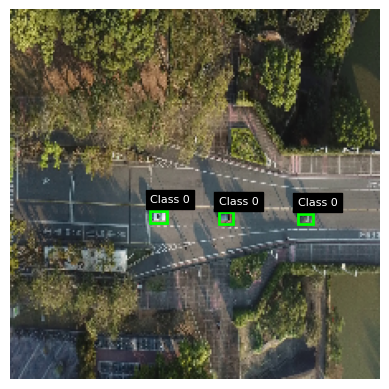

In [11]:
image_path = "/content/yolo/train/images/000003.jpg"
label_path = "/content/yolo/train/labels/000003.txt"
visualize_sample(image_path, label_path)

In [1]:
!pip install ultralytics

In [6]:
!yolo detect train data=/content/yolo/data.yaml model=yolo11s.pt epochs=30 imgsz=640

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

In [8]:
!yolo detect predict model=runs/detect/train3/weights/best.pt source=yolo/test/images save=True

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs

image 1/599 /content/yolo/test/images/000001.jpg: 384x640 3 sedans, 51.5ms
image 2/599 /content/yolo/test/images/000020.jpg: 384x640 3 sedans, 12.2ms
image 3/599 /content/yolo/test/images/000025.jpg: 384x640 2 sedans, 10.8ms
image 4/599 /content/yolo/test/images/000034.jpg: 384x640 3 sedans, 10.8ms
image 5/599 /content/yolo/test/images/000050.jpg: 384x640 1 sedan, 10.8ms
image 6/599 /content/yolo/test/images/000062.jpg: 384x640 1 sedan, 10.8ms
image 7/599 /content/yolo/test/images/000064.jpg: 384x640 1 sedan, 10.8ms
image 8/599 /content/yolo/test/images/000073.jpg: 384x640 1 sedan, 1 minibus, 1 truck, 10.8ms
image 9/599 /content/yolo/test/images/000074.jpg: 384x640 1 minibus, 1 truck, 10.8ms
image 10/599 /content/yolo/test/images/000075.jpg: 384x640 1 minibus, 1 truck, 10.8ms
image 11/599 /content/yolo/test/images/000081

In [9]:
!zip -r result_yolov11s.zip runs

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train2/ (stored 0%)
  adding: runs/detect/train2/weights/ (stored 0%)
  adding: runs/detect/train2/args.yaml (deflated 53%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/weights/ (stored 0%)
  adding: runs/detect/train/args.yaml (deflated 53%)
  adding: runs/detect/train3/ (stored 0%)
  adding: runs/detect/train3/train_batch1.jpg (deflated 4%)
  adding: runs/detect/train3/results.csv (deflated 62%)
  adding: runs/detect/train3/weights/ (stored 0%)
  adding: runs/detect/train3/weights/last.pt (deflated 8%)
  adding: runs/detect/train3/weights/best.pt (deflated 8%)
  adding: runs/detect/train3/R_curve.png (deflated 10%)
  adding: runs/detect/train3/val_batch1_pred.jpg (deflated 5%)
  adding: runs/detect/train3/labels.jpg (deflated 34%)
  adding: runs/detect/train3/val_batch0_labels.jpg (deflated 4%)
  adding: runs/detect/train3/confusion_matrix_normalized.png (deflated 20%)
  addin

In [11]:
from google.colab import drive
drive.mount('/content/drive')

!cp result_yolov11s.zip /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
